<a href="https://colab.research.google.com/github/kenza-c/M2BIGDATA/blob/main/REC_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import transformers
from transformers import pipeline
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import spacy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
import random

In [8]:
from spacy.lang.fr.stop_words import STOP_WORDS

In [9]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 50.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
df_reclamations=pd.read_excel("/content/Rec_kenza.xlsx")

In [11]:
df_reclamations.head()

,REFERENCE,DATREC,DAT_ENRGREC,NUMCPT,MAIL_CLT,MAIL_ENV_CLT,FICHIERJOINT,UTILISATEUR,SUPPORT,DATOPER,...,DESCRIPTION,MOTIF_CLOTURE,TYPE_RECLAM,DATTRAIT,DATE_CLOTURE,SORT,DESCRIPTION_SORT,MOTIF_CLO,SEGMENT_NMR,SPECIFICITE
0,R/00898474/2024,2024-01-01,2024-01-02,NaN,NaN,NaN,NaN,2074,SITE WEB,2024-01-02 09:49:03,...,"BONJOUR,_x000D_\n_x000D_\nJE N ARRIVE PAS À ME...",NOUS VOUS INFORMONS QUE VOTRE DEMANDE SOUS LA...,RECLAMATION,2024-01-04 10:35:32,2024-01-04,Validation traitement,"POUR OBTENIR LE NOUVEAU MOT DE PASSE, NOUS VOU...",NaN,NOUVEAU CLIENT,4
1,R/00898546/2024,2024-01-02,2024-01-02,NaN,NaN,NaN,NaN,2098,MAIL,2024-01-02 11:42:25,...,BONJOUR_x000D_\n_x000D_\nAPUREMENT COMPTE CART...,OD valide au niveau DELTA. Reclamation traitee...,RECLAMATION,2024-01-02 13:34:58,2024-01-03,Validation traitement,nf,NaN,S1 EXCELLENCE,PRIVILEGE
2,R/00898578/2024,2024-01-02,2024-01-02,NaN,NaN,NaN,4937.pdf,2021,COURRIER,2024-01-02 14:23:46,...,ANNULATION ENCAISSEMENT CHQ VERS SUR CPTE EN D...,OD valide au niveau DELTA. Reclamation traitee...,RECLAMATION,2024-01-02 14:31:21,2024-01-03,Validation traitement,od validée merci de clôturer le compte,NaN,NOUVEAU CLIENT,4
3,R/00905876/2024,2024-01-02,2024-02-01,NaN,NaN,NaN,CH2000.pdf,2837,VISITE,2024-02-01 10:14:30,...,DEBLOC AGE PROVISION CH REJETE PAP _x000D_\n_x...,OD valide au niveau DELTA. Reclamation traitee...,RECLAMATION,2024-02-01 14:54:58,2024-02-02,Validation traitement,nf,NaN,S4 AVENIR,NaN
4,R/00898673/2024,2024-01-02,2024-01-02,NaN,NaN,NaN,NaN,4724,VISITE,2024-01-02 15:34:55,...,AC2 REAL TIME BLOQUÉ MERCI D'INTERVENIR,NOUS VOUS INFORMONS QUE VOTRE DEMANDE SOUS LA...,RECLAMATION,2024-01-04 14:05:55,2024-01-04,Validation traitement,Abonnement débloqué. Un nouveau mot de passe v...,NaN,S2 PREMIUM,PRESTIGE


In [12]:
df_clients = pd.read_csv("/content/table_client.txt",delimiter = ';')
# Éliminer les lignes qui n'ont pas d'ID
df_clients1 = df_clients.dropna(subset=['Id_client'])

# Réinitialiser l'index après avoir supprimé des lignes
df_clients2 = df_clients1.reset_index(drop=True)

df_clients_VF = df_clients2.sample(n=3500)

In [13]:
df_clients_VF.head(50)

,Id_client,Tranche_age,Sexe,Nationalite,Situation_familiale,CSP,Secteur_activite,Type_marche,Type_personne,Ville,Code_postal,Pays,Statut_client,Agence_rattachement
18656,18657.0,46-55 ans,Homme,Tunisienne,Marié(e),Ouvrier,Administration publique,Particulier,Physique,Zaghouan,1200.0,Tunisie,Prospect,7.0
21020,21021.0,36-45 ans,Femme,Tunisienne,Marié(e),Cadre moyens,Intermediation financière,Professionnel,Morale,Béja,1000.0,Tunisie,Client,183.0
11952,11953.0,46-55 ans,Homme,Tunisienne,Célibataire,Commerçants - Habillement,Agroalimentaire,Services personnels,Morale,Tozeur,2200.0,Tunisie,Client,99.0
3076,3077.0,36-45 ans,Femme,Tunisienne,Célibataire,Retraité,Automobile,Professionnel,Morale,Sousse,1200.0,Tunisie,Prospect,217.0
782,783.0,56 ans et plus,Femme,Tunisienne,Divorcé(e),Cadre moyens,Police,Particulier,Physique,Kairouan,4000.0,Tunisie,Prospect,107.0
13370,13371.0,26-35 ans,Homme,Tunisienne,Marié(e),Professeur secondaire,Police,TPE PERSONNE PHYSIQUE,Morale,Gafsa,6000.0,Tunisie,Client,209.0
3683,3684.0,26-35 ans,Homme,Tunisienne,Divorcé(e),Employé,Activites hospitalières,Services personnels,Morale,Kébili,2080.0,Tunisie,Prospect,6.0
17347,17348.0,56 ans et plus,Homme,Tunisienne,Veuf(ve),Professeur secondaire,Commerce de gros d'habillement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20295,20296.0,36-45 ans,Homme,Tunisienne,Divorcé(e),Ouvrier,Boulangerie/Patisserie,Services personnels,Morale,Kébili,9000.0,Tunisie,Client,32.0
11007,11008.0,18-25 ans,Femme,Tunisienne,Célibataire,Professeur primaire,Extraction de petrole brut,Services personnels,Morale,Mahdia,5000.0,Tunisie,Prospect,210.0


In [14]:
df_clients_VF.to_csv('df_clients_VF.csv', index=False)

In [15]:
client_ids = df_clients_VF['Id_client'].unique()

In [16]:
client_ids = np.repeat(client_ids, np.random.randint(1, 5, size=len(client_ids)))

In [17]:
if len(df_reclamations) < len(client_ids):
    client_ids = client_ids[:len(df_reclamations)]

df_reclamations['Id_client'] = client_ids

In [18]:
df_reclamations.to_csv('reclamations_modifie.csv', index=False)

In [19]:
new_client_ids = []

# Pour chaque id_client dans client_ids
for Id_client in client_ids:
    # Générer un nombre aléatoire entre 1 et 4
    num_reclamations = np.random.randint(1, 5)

    # Ajouter l'id_client à new_client_ids pour chaque réclamation
    new_client_ids.extend([Id_client] * num_reclamations)

# Si df_reclamations a moins de lignes que new_client_ids, nous allons réduire new_client_ids
if len(df_reclamations) < len(new_client_ids):
    new_client_ids = new_client_ids[:len(df_reclamations)]

df_reclamations['Id_client'] = new_client_ids

In [20]:
df_reclamations.to_csv('reclamations_modifie_V1.csv', index=False)

In [21]:
# Effectuer l'opération de fusion
df_clients_reclamations = pd.merge(df_clients, df_reclamations, on='Id_client', how='inner')

In [22]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [23]:
df_reclamations = df_reclamations.drop('MOTIF_CLO', axis=1)

In [24]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [25]:
# Extraire les lignes où statut_client est égal à 'Prospect'
df_prospect = df_clients_reclamations[df_clients_reclamations['Statut_client'] == 'Prospect']

In [26]:
# Enregistrer le DataFrame extrait dans un nouveau fichier csv
df_prospect.to_csv('prospect.csv', index=False)

In [27]:
print(df_clients_reclamations.describe())

          Id_client  Code_postal  Agence_rattachement  \
count   4499.000000  4265.000000          4265.000000   
mean   11356.389864  3908.049707           122.551934   
min       16.000000  1000.000000             1.000000   
25%     5409.000000  2080.000000            59.000000   
50%    11436.000000  3200.000000           128.000000   
75%    17368.000000  5100.000000           185.000000   
max    22739.000000  9000.000000           235.000000   
std     6640.372114  2328.043573            70.179846   

                              DATREC                    DAT_ENRGREC  NUMCPT  \
count                           4499                           4499     0.0   
mean   2024-02-07 15:53:48.717492736  2024-02-08 12:59:03.187374848     NaN   
min              2024-01-01 00:00:00            2024-01-02 00:00:00     NaN   
25%              2024-01-17 00:00:00            2024-01-17 00:00:00     NaN   
50%              2024-02-01 00:00:00            2024-02-02 00:00:00     NaN   
75%         

In [28]:
df_clients_reclamations.info

<bound method DataFrame.info of       Id_client     Tranche_age   Sexe Nationalite Situation_familiale  \
0          16.0  56 ans et plus  Homme  Tunisienne            Marié(e)   
1          16.0  56 ans et plus  Homme  Tunisienne            Marié(e)   
2          16.0  56 ans et plus  Homme  Tunisienne            Marié(e)   
3          16.0  56 ans et plus  Homme  Tunisienne            Marié(e)   
4          16.0  56 ans et plus  Homme  Tunisienne            Marié(e)   
...         ...             ...    ...         ...                 ...   
4494    22739.0       18-25 ans  Femme  Tunisienne          Divorcé(e)   
4495    22739.0       18-25 ans  Femme  Tunisienne          Divorcé(e)   
4496    22739.0       18-25 ans  Femme  Tunisienne          Divorcé(e)   
4497    22739.0       18-25 ans  Femme  Tunisienne          Divorcé(e)   
4498    22739.0       18-25 ans  Femme  Tunisienne          Divorcé(e)   

                         CSP  Secteur_activite    Type_marche Type_personne  \
0      Professeur secondaire          Services            TRE        Morale   
1      Professeur secondaire          Services            TRE        Morale   
2      Professeur secondaire          Services            TRE        Morale   
3      Professeur secondaire          Services            TRE        Morale   
4      Professeur secondaire          Services            TRE        Morale   
...                      ...               ...            ...           ...   
4494  Dirigeant d'entreprise  Banque/Assurance  Professionnel        Morale   
4495  Dirigeant d'entreprise  Banque/Assurance  Professionnel        Morale   
4496  Dirigeant d'entreprise  Banque/Assurance  Professionnel        Morale   
4497  Dirigeant d'entreprise  Banque/Assurance  Professionnel        Morale   
4498  Dirigeant d'entreprise  Banque/Assurance  Professionnel        Morale   

       Ville  ...                                        DESCRIPTION  \
0     Mahdia  ...                               BLOCAGE NON UTILISÉ    
1     Mahdia  ...  LA RELATION WEBANK N'ARRIVE PAS A CONSULTER LE...   
2     Mahdia  ...           RÉGULARISATION CPTE CARTE TECH DEBITEUR    
3     Mahdia  ...  BONOUR,_x000D_\n_x000D_\nPRIÈRE DE NOUS VALIDE...   
4     Mahdia  ...  BONJOUR _x000D_\n_x000D_\nPRIÈRE DE VALIDER L'...   
...      ...  ...                                                ...   
4494    Sfax  ...  REDRESSEMENT RETRAIT ESPECES EFFECTUE PAR ERRE...   
4495    Sfax  ...  RETARD DE TRAITEMENT DE CONTRAT D'HYPOTHÈQUE _...   
4496    Sfax  ...  BONJOUR,_x000D_\n_x000D_\nPRIERE DE DEBLOQUER ...   
4497    Sfax  ...  _x000D_\n_x000D_\nBONJOUR,_x000D_\n_x000D_\nPR...   
4498    Sfax  ...  BONJOUR,_x000D_\n_x000D_\nPRIERE DE DEBLOQUER ...   

                                          MOTIF_CLOTURE  TYPE_RECLAM  \
0     OD valide au niveau DELTA. Reclamation traitee...  RECLAMATION   
1      NOUS VOUS INFORMONS QUE VOTRE DEMANDE SOUS LA...  RECLAMATION   
2     OD valide au niveau DELTA. Reclamation traitee...  RECLAMATION   
3     OD non valide au niveau DELTA. Reclamation tra...  RECLAMATION   
4     OD non valide au niveau DELTA. Reclamation tra...  RECLAMATION   
...                                                 ...          ...   
4494  OD valide au niveau DELTA. Reclamation traitee...  RECLAMATION   
4495   NOUS VOUS INFORMONS QUE VOTRE DEMANDE SOUS LA...  RECLAMATION   
4496  OD valide au niveau DELTA. Reclamation traitee...  RECLAMATION   
4497  OD valide au niveau DELTA. Reclamation traitee...  RECLAMATION   
4498  OD valide au niveau DELTA. Reclamation traitee...  RECLAMATION   

                DATTRAIT DATE_CLOTURE                   SORT  \
0    2024-02-09 13:45:59   2024-02-10  Validation traitement   
1    2024-02-09 10:23:57   2024-02-09  Validation traitement   
2    2024-02-09 10:11:37   2024-02-10  Validation traitement   
3    2024-02-09 11:11:03   2024-02-10       Manque documents   
4    2024-02-12 13:59:53   2024-02-13       Manque documents   
...             

In [29]:
df_clients_reclamations.dtypes

Id_client                     float64
Tranche_age                    object
Sexe                           object
Nationalite                    object
Situation_familiale            object
CSP                            object
Secteur_activite               object
Type_marche                    object
Type_personne                  object
Ville                          object
Code_postal                   float64
Pays                           object
Statut_client                  object
Agence_rattachement           float64
REFERENCE                      object
DATREC                 datetime64[ns]
DAT_ENRGREC            datetime64[ns]
NUMCPT                        float64
MAIL_CLT                      float64
MAIL_ENV_CLT                  float64
FICHIERJOINT                   object
UTILISATEUR                     int64
SUPPORT                        object
DATOPER                datetime64[ns]
OBSERVATION                    object
TYPDOC                         object
NUMDOC      

In [30]:
# Remplacer '56 ans et plus' par '56<=' dans la colonne Tranche_age
df_clients_reclamations['Tranche_age'] = df_clients_reclamations['Tranche_age'].replace('56 ans et plus', '56<=')

In [31]:
# Initialize the sentiment analysis model
sentiment_model = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [32]:
# Preprocess the data
def preprocess_data(text):
    # Replace any HTML tags with an empty string
    text = re.sub('<.*?>', '', text)
    # Replace any non-alphabetic characters with a space
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    # Return the preprocessed text
    return text

In [33]:
# Preprocess the review text
df_clients_reclamations['DESC_CLEAN'] = df_clients_reclamations['DESCRIPTION'].apply(preprocess_data)

In [34]:
df_clients_reclamations['DESC_CLEAN']

0                                    blocage non utilis  
1       la relation webank n arrive pas a consulter le...
2                r gularisation cpte carte tech debiteur 
3       bonour  x   d   x   d  pri re de nous valider ...
4       bonjour  x   d   x   d  pri re de valider l   ...
                              ...                        
4494    redressement retrait especes effectue par erre...
4495    retard de traitement de contrat d hypoth que  ...
4496    bonjour  x   d   x   d  priere de debloquer la...
4497     x   d   x   d  bonjour  x   d   x   d  priere...
4498    bonjour  x   d   x   d  priere de debloquer la...
Name: DESC_CLEAN, Length: 4499, dtype: object

In [35]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [36]:
def get_sentiment_textblob(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity

    return sentiment

In [37]:
def analyze_sentiment(df, column, sentiment_func):
    df[column + '_sentiment'] = df[column].apply(sentiment_func)

    return df

In [38]:
df_clients_reclamations = analyze_sentiment(df_clients_reclamations, 'DESC_CLEAN', get_sentiment_textblob)

In [39]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [40]:
print(df_clients_reclamations.columns)

Index(['Id_client', 'Tranche_age', 'Sexe', 'Nationalite',
       'Situation_familiale', 'CSP', 'Secteur_activite', 'Type_marche',
       'Type_personne', 'Ville', 'Code_postal', 'Pays', 'Statut_client',
       'Agence_rattachement', 'REFERENCE', 'DATREC', 'DAT_ENRGREC', 'NUMCPT',
       'MAIL_CLT', 'MAIL_ENV_CLT', 'FICHIERJOINT', 'UTILISATEUR', 'SUPPORT',
       'DATOPER', 'OBSERVATION', 'TYPDOC', 'NUMDOC', 'CHARG_CLIENT',
       'DESCRIPTION', 'MOTIF_CLOTURE', 'TYPE_RECLAM', 'DATTRAIT',
       'DATE_CLOTURE', 'SORT', 'DESCRIPTION_SORT', 'MOTIF_CLO', 'SEGMENT_NMR',
       'SPECIFICITE', 'DESC_CLEAN', 'DESC_CLEAN_sentiment'],
      dtype='object')


In [41]:
# Add a new column called 'sentiment'
df_clients_reclamations['sentiment'] = 0.0

# Loop through each reclamation and calculate its sentiment score
for i, row in df_clients_reclamations.iterrows():
    text = row['DESC_CLEAN']
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    df_clients_reclamations.at[i, 'sentiment'] = sentiment_score

# Display the updated DataFrame
print(df_clients_reclamations.head())

   Id_client Tranche_age   Sexe Nationalite Situation_familiale  \
0       16.0        56<=  Homme  Tunisienne            Marié(e)   
1       16.0        56<=  Homme  Tunisienne            Marié(e)   
2       16.0        56<=  Homme  Tunisienne            Marié(e)   
3       16.0        56<=  Homme  Tunisienne            Marié(e)   
4       16.0        56<=  Homme  Tunisienne            Marié(e)   

                     CSP Secteur_activite Type_marche Type_personne   Ville  \
0  Professeur secondaire         Services         TRE        Morale  Mahdia   
1  Professeur secondaire         Services         TRE        Morale  Mahdia   
2  Professeur secondaire         Services         TRE        Morale  Mahdia   
3  Professeur secondaire         Services         TRE        Morale  Mahdia   
4  Professeur secondaire         Services         TRE        Morale  Mahdia   

   ...            DATTRAIT DATE_CLOTURE                   SORT  \
0  ... 2024-02-09 13:45:59   2024-02-10  Validation trai

In [42]:
df_clients_reclamations['DESCRIPTION'] = df_clients_reclamations['DESCRIPTION'].astype(str)
df_clients_reclamations['DESCRIPTION'] = df_clients_reclamations['DESCRIPTION'].fillna('').astype(str)

In [43]:
def clean_text(text):
    """
    Clean text data for sentiment analysis.

    Parameters:
    text (str): Text data

    Returns:
    str: Cleaned text data
    """

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Replace "xd" with an empty string
    text = text.replace("xd", "")

    # Convert to lowercase
    text = text.lower()

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove stop words
    stop = stopwords.words('french')
    filtered_tokens = [token for token in text.split() if token not in stop]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text


In [44]:
df_clients_reclamations['cleaned_reclamation'] = df_clients_reclamations['DESCRIPTION'].apply(clean_text)

In [45]:
df_clients_reclamations['cleaned_reclamation'].head()

0                                   blocage non utilis
1    relation webank narrive a consulter compte via...
2               rgularisation cpte carte tech debiteur
3    bonourxd xd prire valider lod xd cj accord dir...
4    bonjour xd xd prire valider lod suite accord d...
Name: cleaned_reclamation, dtype: object

In [46]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [47]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def analyze_sentiment(text):
    """
    Analyze the sentiment of a given text.

    Parameters:
    text (str): Text data

    Returns:
    str: Sentiment label
    """

    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)

    if sentiment_scores['compound'] >= 0.05:
        sentiment_label = 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'

    return sentiment_label

df_clients_reclamations['sentiment'] = df_clients_reclamations['cleaned_reclamation'].apply(analyze_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


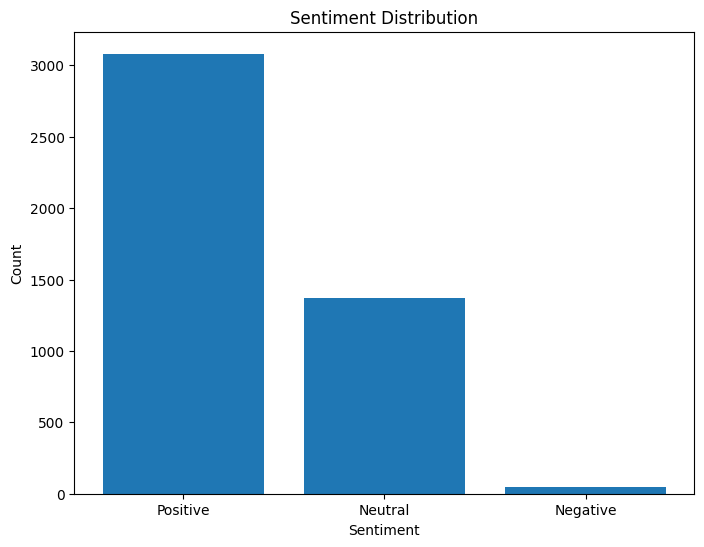

In [48]:
import matplotlib.pyplot as plt

sentiments = df_clients_reclamations['sentiment'].value_counts()

plt.figure(figsize=(8,6))
plt.bar(sentiments.index, sentiments.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [49]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X = df_clients_reclamations['cleaned_reclamation']
y = df_clients_reclamations['DESC_CLEAN_sentiment']  # replace 'sentiment_score' with your sentiment score column

# split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# create new DataFrames
df_train = pd.DataFrame(X_train, columns=['cleaned_reclamation'])
df_train['DESC_CLEAN_sentiment'] = y_train

df_val = pd.DataFrame(X_val, columns=['cleaned_reclamation'])
df_val['DESC_CLEAN_sentiment'] = y_val

In [52]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Pre-processing of data
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]', ' ', str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('french'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

lm = WordNetLemmatizer()

# Apply pre-processing
X_train_preprocessed = text_transformation(df_train['cleaned_reclamation'])
X_val_preprocessed = text_transformation(df_val['cleaned_reclamation'])

# Vectorization
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_preprocessed)
X_val_vectorized = vectorizer.transform(X_val_preprocessed)

# Train the model
model = LinearRegression()
model.fit(X_train_vectorized, df_train['DESC_CLEAN_sentiment'])

# Model evaluation
y_train_pred = model.predict(X_train_vectorized)
y_val_pred = model.predict(X_val_vectorized)

train_mse = mean_squared_error(df_train['DESC_CLEAN_sentiment'], y_train_pred)
train_r2 = r2_score(df_train['DESC_CLEAN_sentiment'], y_train_pred)

val_mse = mean_squared_error(df_val['DESC_CLEAN_sentiment'], y_val_pred)
val_r2 = r2_score(df_val['DESC_CLEAN_sentiment'], y_val_pred)

print("Train MSE: ", train_mse)
print("Train R2: ", train_r2)

print("Validation MSE: ", val_mse)
print("Validation R2: ", val_r2)

Train MSE:  0.00015593182603936223
Train R2:  0.9957942238324279
Validation MSE:  0.02017260191855113
Validation R2:  0.5005357709686433


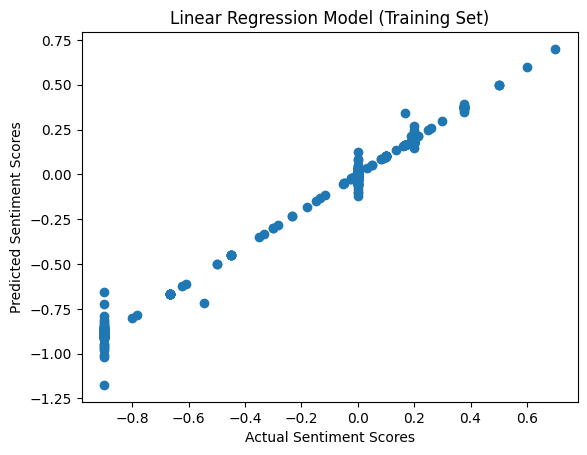

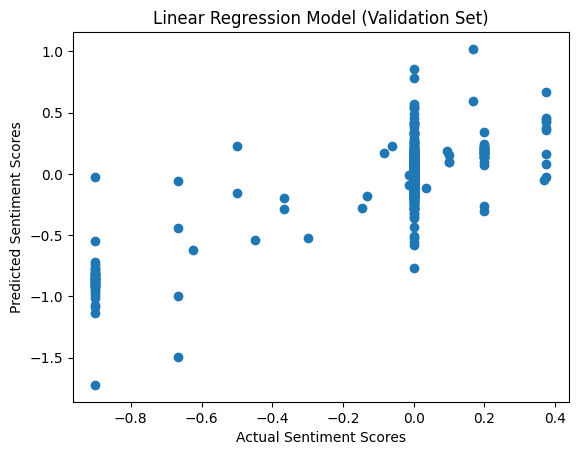

In [53]:
import matplotlib.pyplot as plt

# Plot actual sentiment scores vs. predicted sentiment scores
plt.scatter(df_train['DESC_CLEAN_sentiment'], y_train_pred)
plt.xlabel('Actual Sentiment Scores')
plt.ylabel('Predicted Sentiment Scores')
plt.title('Linear Regression Model (Training Set)')
plt.show()

plt.scatter(df_val['DESC_CLEAN_sentiment'], y_val_pred)
plt.xlabel('Actual Sentiment Scores')
plt.ylabel('Predicted Sentiment Scores')
plt.title('Linear Regression Model (Validation Set)')
plt.show()

In [54]:
df_train['sentiment_score'] = df_train['cleaned_reclamation'].apply(lambda x: model.predict(vectorizer.transform([x]))[0])
df_val['sentiment_score'] = df_val['cleaned_reclamation'].apply(lambda x: model.predict(vectorizer.transform([x]))[0])

In [55]:
df_train['sentiment_score']

4136    0.200024
2715    0.201163
2138   -0.899711
605     0.002913
3844   -0.000018
          ...   
4426   -0.000012
466     0.015235
3092   -0.000001
3772   -0.001986
860    -0.000007
Name: sentiment_score, Length: 3599, dtype: float64

In [56]:
df_val['sentiment_score']

1632   -0.056035
3685   -0.007346
2973   -0.006541
2991   -0.260955
468     0.032379
          ...   
911    -0.217293
809     0.413928
2939   -0.001342
4308    0.027669
3256    0.015473
Name: sentiment_score, Length: 900, dtype: float64

In [57]:
def predict_sentiment_score(row):
    input_ids = vectorizer.transform([row['cleaned_reclamation']])
    return model.predict(input_ids)[0]

In [58]:
df_clients_reclamations['sentiment_score'] = df_clients_reclamations.apply(predict_sentiment_score, axis=1)

In [59]:
def predict_sentiment_score(row):
    input_ids = vectorizer.transform([row['cleaned_reclamation']])
    return model.predict(input_ids)[0]

df_clients_reclamations['sentiment_score'] = df_clients_reclamations.apply(predict_sentiment_score, axis=1)

print(df_clients_reclamations.head())

   Id_client Tranche_age   Sexe Nationalite Situation_familiale  \
0       16.0        56<=  Homme  Tunisienne            Marié(e)   
1       16.0        56<=  Homme  Tunisienne            Marié(e)   
2       16.0        56<=  Homme  Tunisienne            Marié(e)   
3       16.0        56<=  Homme  Tunisienne            Marié(e)   
4       16.0        56<=  Homme  Tunisienne            Marié(e)   

                     CSP Secteur_activite Type_marche Type_personne   Ville  \
0  Professeur secondaire         Services         TRE        Morale  Mahdia   
1  Professeur secondaire         Services         TRE        Morale  Mahdia   
2  Professeur secondaire         Services         TRE        Morale  Mahdia   
3  Professeur secondaire         Services         TRE        Morale  Mahdia   
4  Professeur secondaire         Services         TRE        Morale  Mahdia   

   ...                   SORT  \
0  ...  Validation traitement   
1  ...  Validation traitement   
2  ...  Validation trai

In [60]:
def assign_sentiment_label(score):
    if score <= 0.0:
        return 'Negative'
    else:
        return 'Positive'

In [61]:
df_clients_reclamations['sentiment_label'] = df_clients_reclamations['sentiment_score'].apply(assign_sentiment_label)

In [62]:
def assign_sentiment_label(score):
    if score <= -0.5:
        return 'Negative'
    elif score < 0.5:
        return 'Neutral'
    else:
        return 'Positive'

In [63]:
df_clients_reclamations['sentiment_label_2'] = df_clients_reclamations['sentiment_score'].apply(assign_sentiment_label)

In [64]:
df_clients_reclamations['sentiment_label_2']

0        Neutral
1        Neutral
2        Neutral
3        Neutral
4        Neutral
          ...   
4494     Neutral
4495    Negative
4496     Neutral
4497     Neutral
4498     Neutral
Name: sentiment_label_2, Length: 4499, dtype: object

In [65]:
df_clients_reclamations['sentiment_label']

0       Negative
1       Positive
2       Negative
3       Positive
4       Negative
          ...   
4494    Negative
4495    Negative
4496    Positive
4497    Positive
4498    Positive
Name: sentiment_label, Length: 4499, dtype: object

In [66]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [67]:
from textblob import TextBlob

def textblob_sentiment_analysis(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0.5:
        return 'Positive'
    elif polarity < -0.5:
        return 'Negative'
    else:
        return 'Neutral'

In [68]:
df_clients_reclamations['textblob_sentiment_label'] = df_clients_reclamations['cleaned_reclamation'].apply(textblob_sentiment_analysis)

In [69]:
def textblob_sentiment_score(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return polarity

df_clients_reclamations['textblob_sentiment_score'] = df_clients_reclamations['cleaned_reclamation'].apply(textblob_sentiment_score)

In [70]:
df_clients_reclamations['textblob_sentiment_score']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4494    0.0
4495   -0.9
4496    0.0
4497    0.0
4498    0.0
Name: textblob_sentiment_score, Length: 4499, dtype: float64

In [71]:
df_clients_reclamations['textblob_sentiment_score'].head(60)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.2
15    0.0
16    0.2
17    0.0
18   -0.9
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
45    0.0
46    0.0
47    0.0
48    0.0
49    0.0
50    0.0
51    0.0
52    0.0
53    0.0
54    0.0
55    0.0
56    0.0
57    0.0
58    0.0
59    0.0
Name: textblob_sentiment_score, dtype: float64

In [72]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [73]:
import nltk
nltk.download('vader_lexicon')
sid=SentimentIntensityAnalyzer()
ps=lambda x:sid.polarity_scores(x)
sentiment_scores_vader=df_clients_reclamations.cleaned_reclamation.apply(ps)
sentiment_scores_vader

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1       {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
2       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3       {'neg': 0.0, 'neu': 0.568, 'pos': 0.432, 'comp...
4       {'neg': 0.0, 'neu': 0.367, 'pos': 0.633, 'comp...
                              ...                        
4494    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4495    {'neg': 0.258, 'neu': 0.455, 'pos': 0.288, 'co...
4496    {'neg': 0.0, 'neu': 0.441, 'pos': 0.559, 'comp...
4497    {'neg': 0.0, 'neu': 0.321, 'pos': 0.679, 'comp...
4498    {'neg': 0.0, 'neu': 0.441, 'pos': 0.559, 'comp...
Name: cleaned_reclamation, Length: 4499, dtype: object

In [74]:
sentiment_df=pd.DataFrame(data=list(sentiment_scores_vader))
display(sentiment_df)

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.000,0.631,0.369,0.9451
2,0.000,1.000,0.000,0.0000
3,0.000,0.568,0.432,0.8225
4,0.000,0.367,0.633,0.9638
...,...,...,...,...
4494,0.000,1.000,0.000,0.0000
4495,0.258,0.455,0.288,0.1027
4496,0.000,0.441,0.559,0.9081
4497,0.000,0.321,0.679,0.9638


In [75]:
labelize=lambda x:'neutral' if x==0 else('positive' if x>0 else 'negative')
sentiment_df['label_vader']=sentiment_df.compound.apply(labelize)
display(sentiment_df.head(10))

,neg,neu,pos,compound,label_vader
0,0.0,1.000,0.000,0.0000,neutral
1,0.0,0.631,0.369,0.9451,positive
2,0.0,1.000,0.000,0.0000,neutral
3,0.0,0.568,0.432,0.8225,positive
4,0.0,0.367,0.633,0.9638,positive
5,0.0,1.000,0.000,0.0000,neutral
6,0.0,0.542,0.458,0.8225,positive
7,0.0,1.000,0.000,0.0000,neutral
8,0.0,1.000,0.000,0.0000,neutral
9,0.0,1.000,0.000,0.0000,neutral


In [76]:
display(df_clients_reclamations.head(5))
data=df_clients_reclamations.join(sentiment_df.label_vader)
display(data.head(5))

,Id_client,Tranche_age,Sexe,Nationalite,Situation_familiale,CSP,Secteur_activite,Type_marche,Type_personne,Ville,...,SPECIFICITE,DESC_CLEAN,DESC_CLEAN_sentiment,sentiment,cleaned_reclamation,sentiment_score,sentiment_label,sentiment_label_2,textblob_sentiment_label,textblob_sentiment_score
0,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,NaN,blocage non utilis,0.0,Neutral,blocage non utilis,-0.003482,Negative,Neutral,Neutral,0.0
1,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,NaN,la relation webank n arrive pas a consulter le...,0.0,Positive,relation webank narrive a consulter compte via...,0.000009,Positive,Neutral,Neutral,0.0
2,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,NaN,r gularisation cpte carte tech debiteur,0.0,Neutral,rgularisation cpte carte tech debiteur,-0.001648,Negative,Neutral,Neutral,0.0
3,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,NaN,bonour x d x d pri re de nous valider ...,0.0,Positive,bonourxd xd prire valider lod xd cj accord dir...,0.000019,Positive,Neutral,Neutral,0.0
4,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,NaN,bonjour x d x d pri re de valider l ...,0.0,Positive,bonjour xd xd prire valider lod suite accord d...,-0.000025,Negative,Neutral,Neutral,0.0


,Id_client,Tranche_age,Sexe,Nationalite,Situation_familiale,CSP,Secteur_activite,Type_marche,Type_personne,Ville,...,DESC_CLEAN,DESC_CLEAN_sentiment,sentiment,cleaned_reclamation,sentiment_score,sentiment_label,sentiment_label_2,textblob_sentiment_label,textblob_sentiment_score,label_vader
0,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,blocage non utilis,0.0,Neutral,blocage non utilis,-0.003482,Negative,Neutral,Neutral,0.0,neutral
1,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,la relation webank n arrive pas a consulter le...,0.0,Positive,relation webank narrive a consulter compte via...,0.000009,Positive,Neutral,Neutral,0.0,positive
2,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,r gularisation cpte carte tech debiteur,0.0,Neutral,rgularisation cpte carte tech debiteur,-0.001648,Negative,Neutral,Neutral,0.0,neutral
3,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,bonour x d x d pri re de nous valider ...,0.0,Positive,bonourxd xd prire valider lod xd cj accord dir...,0.000019,Positive,Neutral,Neutral,0.0,positive
4,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,bonjour x d x d pri re de valider l ...,0.0,Positive,bonjour xd xd prire valider lod suite accord d...,-0.000025,Negative,Neutral,Neutral,0.0,positive


In [77]:
counts_df=data.label_vader.value_counts().reset_index()
display(counts_df)

,label_vader,count
0,positive,3081
1,neutral,1372
2,negative,46


In [78]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Sélectionner les textes des réclamations
texts = df_clients_reclamations['cleaned_reclamation'].tolist()

# Vectorisation du texte
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

# Entraînement du modèle Naive Bayes
model = MultinomialNB()
model.fit(X, texts)  # Utilisation du texte lui-même comme cible pour une approche non supervisée

# Prédiction sur les données d'entraînement
y_pred = model.predict(X)

# Évaluation de la précision du modèle (approche non supervisée)
accuracy = accuracy_score(texts, y_pred)
print("Précision du modèle : {:.2f}".format(accuracy))

Précision du modèle : 0.33


In [79]:
#TEXTBLOB

# Analyse de sentiment pour chaque texte de la table
for index, row in data.iterrows():
    texte = row['cleaned_reclamation']
    blob = TextBlob(texte)
    polarite = blob.sentiment.polarity
    subjectivite = blob.sentiment.subjectivity

    # Affichage des résultats pour chaque texte
    print("Texte:", texte)
    print("Polarité du sentiment : ", polarite)
    print("Subjectivité du sentiment : ", subjectivite)
    print("\n")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Texte: bonjourxd od relative redressement vers erron date montant dt xd ci joint accord juriste
Polarité du sentiment :  0.0
Subjectivité du sentiment :  0.0


Texte: bonjourxd od relative retrait erron date xd ci joint accord juriste
Polarité du sentiment :  0.0
Subjectivité du sentiment :  0.0


Texte: bonjourxd od relative vers erron date montant dtxd ci joint accord juriste
Polarité du sentiment :  0.0
Subjectivité du sentiment :  0.0


Texte: correction date valeur saieps lors ristourne mettre lieu xd xd xd xd xd xd ristproveps no levee caution fav bureau taxationxd xd xd xd xd
Polarité du sentiment :  0.0
Subjectivité du sentiment :  0.0


Texte: redressement versement intrt placement tnc verser erreur compte dinar xd cijoint extrait compte dossier placement xd xd cdt
Polarité du sentiment :  0.0
Subjectivité du sentiment :  0.0


Texte: bonjourxd xd chque dt prsent montant dt chque ressaisi ctr merci p

Les 30 mots les plus fréquents :
[('xd', 10360), ('compte', 2045), ('bonjourxd', 1211), ('demande', 1173), ('merci', 993), ('a', 991), ('relation', 939), ('client', 916), ('bonjour', 873), ('cdt', 832), ('ci', 755), ('joint', 739), ('montant', 548), ('cordialement', 490), ('cijoint', 472), ('dt', 455), ('suite', 400), ('virement', 389), ('non', 371), ('blocage', 349), ('date', 335), ('veuillez', 331), ('cheque', 314), ('prire', 282), ('dun', 274), ('valider', 272), ('accord', 265), ('rclame', 264), ('chque', 248), ('svp', 238)]


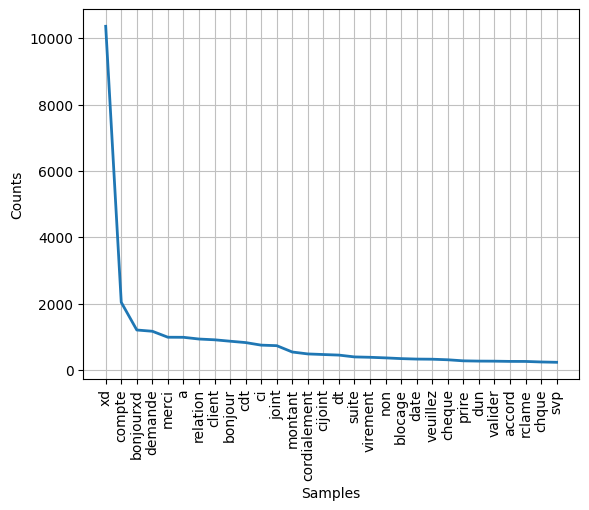

In [80]:

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

# Sélectionner les textes des réclamations
texts = df_clients_reclamations['cleaned_reclamation'].tolist()

# Tokeniser les textes
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# Filtrer les mots vides (stop words)
stop_words = set(stopwords.words('french'))
filtered_texts = [[word for word in text if word.isalnum() and word not in stop_words] for text in tokenized_texts]

# Calculer la fréquence des mots
all_words = [word for text in filtered_texts for word in text]
fdist = FreqDist(all_words)

# Afficher les 10 mots les plus fréquents
print("Les 30 mots les plus fréquents :")
print(fdist.most_common(30))

# Afficher un graphique de la distribution des mots
fdist.plot(30, cumulative=False)
plt.show()

In [81]:
# Sélectionner les textes des réclamations
texts = df_clients_reclamations['cleaned_reclamation'].tolist()

# Tokeniser les textes
tokenizer = nltk.tokenize.word_tokenize
tokenized_texts = [tokenizer(text) for text in texts]

# Extraire les mots-clés
stop_words = set(nltk.corpus.stopwords.words('french'))
keywords = []
for text in tokenized_texts:
    for word in text:
        if word not in stop_words:
            keywords.append(word)

# Afficher les mots-clés
print(keywords)

['blocage', 'non', 'utilis', 'relation', 'webank', 'narrive', 'a', 'consulter', 'compte', 'via', 'canal', 'digital', 'application', 'webankxd', 'nb', 'signature', 'a', 'ete', 'scannee', 'manuellement', 'a', 'agence', 'xd', 'xd', 'message', 'erreur', 'merci', 'terminer', 'procedure', 'ouverture', 'compte', 'xd', 'xd', 'merci', 'regler', 'probleme', 'rgularisation', 'cpte', 'carte', 'tech', 'debiteur', 'bonourxd', 'xd', 'prire', 'valider', 'lod', 'xd', 'cj', 'accord', 'dir', 'groupe', 'dir', 'rgionale', 'bonjour', 'xd', 'xd', 'prire', 'valider', 'lod', 'suite', 'accord', 'dir', 'groupe', 'dir', 'rgional', 'xd', 'xd', 'xd', 'cordialement', 'demande', 'relev', 'compte', 'agence', 'tranfert', 'ben', 'arous', 'ville', 'bonjour', 'xd', 'prire', 'envoyer', 'relve', 'compte', 'xd', 'cijoint', 'demande', 'relation', 'signe', 'bonjourxd', 'cijoint', 'demande', 'extrait', 'compte', 'nom', 'mme', 'nasfi', 'mariem', 'demande', 'releves', 'comptes', 'annee', 'compte', 'cloturexd', 'cijoint', 'demande

In [82]:
def analyser_reclamation(df3):

    # Tokeniser la réclamation
    mots = word_tokenize(df3)

    # Supprimer les stopwords
    mots_utiles = [mot for mot in mots if mot not in stopwords.words('french')]
    return mots_utiles

In [83]:
df_clients_reclamations['mots_utiles'] = df_clients_reclamations['cleaned_reclamation'].apply(analyser_reclamation)

In [84]:
df_clients_reclamations['mots_utiles'].head(50)

0                                [blocage, non, utilis]
1     [relation, webank, narrive, a, consulter, comp...
2          [rgularisation, cpte, carte, tech, debiteur]
3     [bonourxd, xd, prire, valider, lod, xd, cj, ac...
4     [bonjour, xd, xd, prire, valider, lod, suite, ...
5     [demande, relev, compte, agence, tranfert, ben...
6     [bonjour, xd, prire, envoyer, relve, compte, x...
7     [bonjourxd, cijoint, demande, extrait, compte,...
8     [demande, releves, comptes, annee, compte, clo...
9     [demande, releves, compte, annee, cijoint, dem...
10                     [demande, releve, cpte, janvier]
11    [bonjourxd, merci, procder, mise, a, jour, mr,...
12    [bonjourxd, merci, envoyer, lextrait, compte, ...
13                [compte, realtime, bloque, xd, login]
14    [bonjourxd, xd, prire, lever, blocage, lapplic...
15       [laccs, art, relation, bloqu, merci, dbloquer]
16    [bonjourxd, relation, a, bloqu, acc, attijari,...
17    [acces, attijari, mobile, bloquexd, rrinit

In [85]:
df_clients_reclamations.head()

,Id_client,Tranche_age,Sexe,Nationalite,Situation_familiale,CSP,Secteur_activite,Type_marche,Type_personne,Ville,...,DESC_CLEAN,DESC_CLEAN_sentiment,sentiment,cleaned_reclamation,sentiment_score,sentiment_label,sentiment_label_2,textblob_sentiment_label,textblob_sentiment_score,mots_utiles
0,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,blocage non utilis,0.0,Neutral,blocage non utilis,-0.003482,Negative,Neutral,Neutral,0.0,"[blocage, non, utilis]"
1,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,la relation webank n arrive pas a consulter le...,0.0,Positive,relation webank narrive a consulter compte via...,0.000009,Positive,Neutral,Neutral,0.0,"[relation, webank, narrive, a, consulter, comp..."
2,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,r gularisation cpte carte tech debiteur,0.0,Neutral,rgularisation cpte carte tech debiteur,-0.001648,Negative,Neutral,Neutral,0.0,"[rgularisation, cpte, carte, tech, debiteur]"
3,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,bonour x d x d pri re de nous valider ...,0.0,Positive,bonourxd xd prire valider lod xd cj accord dir...,0.000019,Positive,Neutral,Neutral,0.0,"[bonourxd, xd, prire, valider, lod, xd, cj, ac..."
4,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,bonjour x d x d pri re de valider l ...,0.0,Positive,bonjour xd xd prire valider lod suite accord d...,-0.000025,Negative,Neutral,Neutral,0.0,"[bonjour, xd, xd, prire, valider, lod, suite, ..."


In [86]:
stop_words=set(STOP_WORDS)

deselect_stop_words = ['n\'', 'ne','pas','plus','personne','aucun','ni','aucune','rien']
for w in deselect_stop_words:
    if w in stop_words:
        stop_words.remove(w)
    else:
        continue

In [87]:
AllfilteredREC=[]
for cleaned_reclamation in df_clients_reclamations["mots_utiles"]:
    filteredREC = [w for w in cleaned_reclamation if not ((w in stop_words) or (len(w) == 1))]
    AllfilteredREC.append(' '.join(filteredREC))

In [88]:
df_clients_reclamations["DESCAferPreproc"]=AllfilteredREC
df_clients_reclamations.head()

,Id_client,Tranche_age,Sexe,Nationalite,Situation_familiale,CSP,Secteur_activite,Type_marche,Type_personne,Ville,...,DESC_CLEAN_sentiment,sentiment,cleaned_reclamation,sentiment_score,sentiment_label,sentiment_label_2,textblob_sentiment_label,textblob_sentiment_score,mots_utiles,DESCAferPreproc
0,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Neutral,blocage non utilis,-0.003482,Negative,Neutral,Neutral,0.0,"[blocage, non, utilis]",blocage non utilis
1,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Positive,relation webank narrive a consulter compte via...,0.000009,Positive,Neutral,Neutral,0.0,"[relation, webank, narrive, a, consulter, comp...",relation webank narrive consulter compte canal...
2,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Neutral,rgularisation cpte carte tech debiteur,-0.001648,Negative,Neutral,Neutral,0.0,"[rgularisation, cpte, carte, tech, debiteur]",rgularisation cpte carte tech debiteur
3,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Positive,bonourxd xd prire valider lod xd cj accord dir...,0.000019,Positive,Neutral,Neutral,0.0,"[bonourxd, xd, prire, valider, lod, xd, cj, ac...",bonourxd xd prire valider lod xd cj accord dir...
4,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Positive,bonjour xd xd prire valider lod suite accord d...,-0.000025,Negative,Neutral,Neutral,0.0,"[bonjour, xd, xd, prire, valider, lod, suite, ...",bonjour xd xd prire valider lod suite accord d...


In [89]:
texte_reclamation = df_clients_reclamations.cleaned_reclamation

In [90]:
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 57.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [91]:
nlp = spacy.load('fr_core_news_sm')
texte_reclamation = df_clients_reclamations.cleaned_reclamation

In [92]:
docs = texte_reclamation.apply(nlp)

In [93]:
docs.head()

0                               (blocage, non, utilis)
1    (relation, webank, narrive, a, consulter, comp...
2         (rgularisation, cpte, carte, tech, debiteur)
3    (bonourxd, xd, prire, valider, lod, xd, cj, ac...
4    (bonjour, xd, xd, prire, valider, lod, suite, ...
Name: cleaned_reclamation, dtype: object

In [94]:
df_clients_reclamations.head(10)

,Id_client,Tranche_age,Sexe,Nationalite,Situation_familiale,CSP,Secteur_activite,Type_marche,Type_personne,Ville,...,DESC_CLEAN_sentiment,sentiment,cleaned_reclamation,sentiment_score,sentiment_label,sentiment_label_2,textblob_sentiment_label,textblob_sentiment_score,mots_utiles,DESCAferPreproc
0,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Neutral,blocage non utilis,-0.003482,Negative,Neutral,Neutral,0.0,"[blocage, non, utilis]",blocage non utilis
1,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Positive,relation webank narrive a consulter compte via...,0.000009,Positive,Neutral,Neutral,0.0,"[relation, webank, narrive, a, consulter, comp...",relation webank narrive consulter compte canal...
2,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Neutral,rgularisation cpte carte tech debiteur,-0.001648,Negative,Neutral,Neutral,0.0,"[rgularisation, cpte, carte, tech, debiteur]",rgularisation cpte carte tech debiteur
3,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Positive,bonourxd xd prire valider lod xd cj accord dir...,0.000019,Positive,Neutral,Neutral,0.0,"[bonourxd, xd, prire, valider, lod, xd, cj, ac...",bonourxd xd prire valider lod xd cj accord dir...
4,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Positive,bonjour xd xd prire valider lod suite accord d...,-0.000025,Negative,Neutral,Neutral,0.0,"[bonjour, xd, xd, prire, valider, lod, suite, ...",bonjour xd xd prire valider lod suite accord d...
5,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,0.0,Neutral,demande relev compte agence tranfert ben arous...,-0.000022,Negative,Neutral,Neutral,0.0,"[demande, relev, compte, agence, tranfert, ben...",demande relev compte agence tranfert ben arous...
6,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,0.0,Positive,bonjour xd prire envoyer relve compte xd cijoi...,-0.008002,Negative,Neutral,Neutral,0.0,"[bonjour, xd, prire, envoyer, relve, compte, x...",bonjour xd prire envoyer relve compte xd cijoi...
7,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,0.0,Neutral,bonjourxd cijoint demande extrait compte nom m...,-0.000763,Negative,Neutral,Neutral,0.0,"[bonjourxd, cijoint, demande, extrait, compte,...",bonjourxd cijoint demande extrait compte nom m...
8,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,0.0,Neutral,demande releves comptes annee compte cloturexd...,0.033383,Positive,Neutral,Neutral,0.0,"[demande, releves, comptes, annee, compte, clo...",demande releves comptes annee compte cloturexd...
9,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,0.0,Neutral,demande releves compte annee cijoint demande c...,-0.001686,Negative,Neutral,Neutral,0.0,"[demande, releves, compte, annee, cijoint, dem...",demande releves compte annee cijoint demande c...


In [95]:
df_clients_reclamations['mots_utiles'] = df_clients_reclamations['cleaned_reclamation'].apply(analyser_reclamation)

In [96]:
# Sélectionner les textes des réclamations
texts = df_clients_reclamations['cleaned_reclamation'].tolist()

# Tokeniser les textes
tokenizer = nltk.tokenize.word_tokenize
tokenized_texts = [tokenizer(text) for text in texts]

# Extraire les mots-clés
stop_words = set(nltk.corpus.stopwords.words('french'))
keywords = []
for text in tokenized_texts:
    for word in text:
        if word not in stop_words:
            keywords.append(word)

# Afficher les mots-clés
print(keywords)

['blocage', 'non', 'utilis', 'relation', 'webank', 'narrive', 'a', 'consulter', 'compte', 'via', 'canal', 'digital', 'application', 'webankxd', 'nb', 'signature', 'a', 'ete', 'scannee', 'manuellement', 'a', 'agence', 'xd', 'xd', 'message', 'erreur', 'merci', 'terminer', 'procedure', 'ouverture', 'compte', 'xd', 'xd', 'merci', 'regler', 'probleme', 'rgularisation', 'cpte', 'carte', 'tech', 'debiteur', 'bonourxd', 'xd', 'prire', 'valider', 'lod', 'xd', 'cj', 'accord', 'dir', 'groupe', 'dir', 'rgionale', 'bonjour', 'xd', 'xd', 'prire', 'valider', 'lod', 'suite', 'accord', 'dir', 'groupe', 'dir', 'rgional', 'xd', 'xd', 'xd', 'cordialement', 'demande', 'relev', 'compte', 'agence', 'tranfert', 'ben', 'arous', 'ville', 'bonjour', 'xd', 'prire', 'envoyer', 'relve', 'compte', 'xd', 'cijoint', 'demande', 'relation', 'signe', 'bonjourxd', 'cijoint', 'demande', 'extrait', 'compte', 'nom', 'mme', 'nasfi', 'mariem', 'demande', 'releves', 'comptes', 'annee', 'compte', 'cloturexd', 'cijoint', 'demande

In [97]:
df_clients_reclamations['DESCAferPreproc'] = df_clients_reclamations['DESCAferPreproc'].str.replace('xd', '')
df_clients_reclamations['cleaned_reclamation'] = df_clients_reclamations['cleaned_reclamation'].str.replace('xd', '')

In [98]:
def analyser_reclamation(df3):

    # Tokeniser la réclamation
    mots = word_tokenize(df3)

    # Supprimer les stopwords
    mots_utiles = [mot for mot in mots if mot not in stopwords.words('french')]
    return mots_utiles

In [99]:
# Sélectionner les textes des réclamations
texts = df_clients_reclamations['cleaned_reclamation'].tolist()

# Tokeniser les textes
tokenizer = nltk.tokenize.word_tokenize
tokenized_texts = [tokenizer(text) for text in texts]

# Extraire les mots-clés
stop_words = set(nltk.corpus.stopwords.words('french'))
keywords = []
for text in tokenized_texts:
    for word in text:
        if word not in stop_words:
            keywords.append(word)

# Afficher les mots-clés
print(keywords)

['blocage', 'non', 'utilis', 'relation', 'webank', 'narrive', 'a', 'consulter', 'compte', 'via', 'canal', 'digital', 'application', 'webank', 'nb', 'signature', 'a', 'ete', 'scannee', 'manuellement', 'a', 'agence', 'message', 'erreur', 'merci', 'terminer', 'procedure', 'ouverture', 'compte', 'merci', 'regler', 'probleme', 'rgularisation', 'cpte', 'carte', 'tech', 'debiteur', 'bonour', 'prire', 'valider', 'lod', 'cj', 'accord', 'dir', 'groupe', 'dir', 'rgionale', 'bonjour', 'prire', 'valider', 'lod', 'suite', 'accord', 'dir', 'groupe', 'dir', 'rgional', 'cordialement', 'demande', 'relev', 'compte', 'agence', 'tranfert', 'ben', 'arous', 'ville', 'bonjour', 'prire', 'envoyer', 'relve', 'compte', 'cijoint', 'demande', 'relation', 'signe', 'bonjour', 'cijoint', 'demande', 'extrait', 'compte', 'nom', 'mme', 'nasfi', 'mariem', 'demande', 'releves', 'comptes', 'annee', 'compte', 'cloture', 'cijoint', 'demande', 'signee', 'cachetee', 'demande', 'releves', 'compte', 'annee', 'cijoint', 'demande'

In [100]:
df_clients_reclamations['mots_utiles'] = df_clients_reclamations['cleaned_reclamation'].apply(analyser_reclamation)

In [101]:
df_clients_reclamations['mots_utiles'].head(50)

0                                [blocage, non, utilis]
1     [relation, webank, narrive, a, consulter, comp...
2          [rgularisation, cpte, carte, tech, debiteur]
3     [bonour, prire, valider, lod, cj, accord, dir,...
4     [bonjour, prire, valider, lod, suite, accord, ...
5     [demande, relev, compte, agence, tranfert, ben...
6     [bonjour, prire, envoyer, relve, compte, cijoi...
7     [bonjour, cijoint, demande, extrait, compte, n...
8     [demande, releves, comptes, annee, compte, clo...
9     [demande, releves, compte, annee, cijoint, dem...
10                     [demande, releve, cpte, janvier]
11    [bonjour, merci, procder, mise, a, jour, mr, b...
12      [bonjour, merci, envoyer, lextrait, compte, ct]
13                    [compte, realtime, bloque, login]
14    [bonjour, prire, lever, blocage, lapplication,...
15       [laccs, art, relation, bloqu, merci, dbloquer]
16    [bonjour, relation, a, bloqu, acc, attijari, r...
17    [acces, attijari, mobile, bloque, rrinitia

In [102]:
df_clients_reclamations.head(10)

,Id_client,Tranche_age,Sexe,Nationalite,Situation_familiale,CSP,Secteur_activite,Type_marche,Type_personne,Ville,...,DESC_CLEAN_sentiment,sentiment,cleaned_reclamation,sentiment_score,sentiment_label,sentiment_label_2,textblob_sentiment_label,textblob_sentiment_score,mots_utiles,DESCAferPreproc
0,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Neutral,blocage non utilis,-0.003482,Negative,Neutral,Neutral,0.0,"[blocage, non, utilis]",blocage non utilis
1,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Positive,relation webank narrive a consulter compte via...,0.000009,Positive,Neutral,Neutral,0.0,"[relation, webank, narrive, a, consulter, comp...",relation webank narrive consulter compte canal...
2,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Neutral,rgularisation cpte carte tech debiteur,-0.001648,Negative,Neutral,Neutral,0.0,"[rgularisation, cpte, carte, tech, debiteur]",rgularisation cpte carte tech debiteur
3,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Positive,bonour prire valider lod cj accord dir group...,0.000019,Positive,Neutral,Neutral,0.0,"[bonour, prire, valider, lod, cj, accord, dir,...",bonour prire valider lod cj accord dir group...
4,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.0,Positive,bonjour prire valider lod suite accord dir g...,-0.000025,Negative,Neutral,Neutral,0.0,"[bonjour, prire, valider, lod, suite, accord, ...",bonjour prire valider lod suite accord dir g...
5,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,0.0,Neutral,demande relev compte agence tranfert ben arous...,-0.000022,Negative,Neutral,Neutral,0.0,"[demande, relev, compte, agence, tranfert, ben...",demande relev compte agence tranfert ben arous...
6,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,0.0,Positive,bonjour prire envoyer relve compte cijoint d...,-0.008002,Negative,Neutral,Neutral,0.0,"[bonjour, prire, envoyer, relve, compte, cijoi...",bonjour prire envoyer relve compte cijoint d...
7,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,0.0,Neutral,bonjour cijoint demande extrait compte nom mme...,-0.000763,Negative,Neutral,Neutral,0.0,"[bonjour, cijoint, demande, extrait, compte, n...",bonjour cijoint demande extrait compte nom mme...
8,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,0.0,Neutral,demande releves comptes annee compte cloture c...,0.033383,Positive,Neutral,Neutral,0.0,"[demande, releves, comptes, annee, compte, clo...",demande releves comptes annee compte cloture c...
9,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,0.0,Neutral,demande releves compte annee cijoint demande c...,-0.001686,Negative,Neutral,Neutral,0.0,"[demande, releves, compte, annee, cijoint, dem...",demande releves compte annee cijoint demande c...


In [103]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [104]:
def generer_num_doc(TYPDOC):
    if isinstance(TYPDOC, str):
        if 'CIN' in TYPDOC:
            return ''.join(str(np.random.randint(0, 9)) for _ in range(8))
        elif 'Identité Fiscale' in TYPDOC or 'Registre de commerce' in TYPDOC:
            return ''.join(str(np.random.randint(0, 9)) for _ in range(6)) + random.choice(string.ascii_uppercase)
        elif 'Passeport' in TYPDOC:
            return ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(9))
        elif 'Carte de séjour' in TYPDOC:
            return ''.join(str(np.random.randint(0, 9)) for _ in range(10))
    return None  # retourner None si TYPDOC n'est pas une chaîne
df_clients_reclamations['NUM_Doc'] = df_clients_reclamations['TYPDOC'].apply(generer_num_doc)

In [105]:
df_clients_reclamations.NUM_Doc.head(50)

0       621671L
1      83681635
2       761562H
3      88710471
4      02170185
5      05571617
6       123367I
7      30788234
8       630823H
9      18173162
10     68726340
11     05236852
12     74138471
13     35126186
14     83871272
15     32633722
16     68685452
17     55116426
18     36662070
19     07412765
20     35141563
21      485754F
22      526758X
23     68720225
24     37107316
25         None
26     11384686
27     75103264
28      583380Z
29     82732675
30     70314850
31     51715532
32      536408Q
33      341376R
34     27450154
35      320424Q
36     07267480
37     40876322
38     14310141
39     18877272
40      070227Z
41     33824740
42         None
43      638211R
44      333326D
45     32353158
46    l0rqgjieb
47      005455R
48      266533J
49     10218457
Name: NUM_Doc, dtype: object

In [106]:
df_clients_reclamations.dtypes

Id_client                          float64
Tranche_age                         object
Sexe                                object
Nationalite                         object
Situation_familiale                 object
CSP                                 object
Secteur_activite                    object
Type_marche                         object
Type_personne                       object
Ville                               object
Code_postal                        float64
Pays                                object
Statut_client                       object
Agence_rattachement                float64
REFERENCE                           object
DATREC                      datetime64[ns]
DAT_ENRGREC                 datetime64[ns]
NUMCPT                             float64
MAIL_CLT                           float64
MAIL_ENV_CLT                       float64
FICHIERJOINT                        object
UTILISATEUR                          int64
SUPPORT                             object
DATOPER    

In [107]:
# Générer des numéros de compte aléatoires pour toutes les réclamations
df_clients_reclamations['NUMCPT'] = df_clients_reclamations['Id_client'].apply(lambda x: random.randint(1000000000, 9999999999))

In [108]:
df_clients_reclamations.NUMCPT.head()

0    4484398092
1    8445862155
2    1151652621
3    2623203857
4    8742825493
Name: NUMCPT, dtype: int64

In [109]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [110]:
df_clients_reclamations['NUMCPT_2'] = np.nan

In [111]:
nombre_id_client_uniques = df_clients_reclamations['Id_client'].nunique()

In [112]:
nombre_id_client_uniques

749

In [113]:
# Sélectionner 300 ID clients aléatoires
selected_ids = np.random.choice(df_clients_reclamations['Id_client'], 300, replace=False)

In [114]:
# Générer un deuxième numéro de compte pour les ID clients sélectionnés
df_clients_reclamations.loc[df_clients_reclamations['Id_client'].isin(selected_ids), 'NUMCPT_2'] = [random.randint(1000000000, 9999999999) for _ in range(df_clients_reclamations['Id_client'].isin(selected_ids).sum())]

In [115]:
df_clients_reclamations.head(50)

,Id_client,Tranche_age,Sexe,Nationalite,Situation_familiale,CSP,Secteur_activite,Type_marche,Type_personne,Ville,...,cleaned_reclamation,sentiment_score,sentiment_label,sentiment_label_2,textblob_sentiment_label,textblob_sentiment_score,mots_utiles,DESCAferPreproc,NUM_Doc,NUMCPT_2
0,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,blocage non utilis,-0.003482,Negative,Neutral,Neutral,0.0,"[blocage, non, utilis]",blocage non utilis,621671L,NaN
1,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,relation webank narrive a consulter compte via...,0.000009,Positive,Neutral,Neutral,0.0,"[relation, webank, narrive, a, consulter, comp...",relation webank narrive consulter compte canal...,83681635,NaN
2,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,rgularisation cpte carte tech debiteur,-0.001648,Negative,Neutral,Neutral,0.0,"[rgularisation, cpte, carte, tech, debiteur]",rgularisation cpte carte tech debiteur,761562H,NaN
3,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,bonour prire valider lod cj accord dir group...,0.000019,Positive,Neutral,Neutral,0.0,"[bonour, prire, valider, lod, cj, accord, dir,...",bonour prire valider lod cj accord dir group...,88710471,NaN
4,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,bonjour prire valider lod suite accord dir g...,-0.000025,Negative,Neutral,Neutral,0.0,"[bonjour, prire, valider, lod, suite, accord, ...",bonjour prire valider lod suite accord dir g...,02170185,NaN
5,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,demande relev compte agence tranfert ben arous...,-0.000022,Negative,Neutral,Neutral,0.0,"[demande, relev, compte, agence, tranfert, ben...",demande relev compte agence tranfert ben arous...,05571617,NaN
6,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,bonjour prire envoyer relve compte cijoint d...,-0.008002,Negative,Neutral,Neutral,0.0,"[bonjour, prire, envoyer, relve, compte, cijoi...",bonjour prire envoyer relve compte cijoint d...,123367I,NaN
7,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,bonjour cijoint demande extrait compte nom mme...,-0.000763,Negative,Neutral,Neutral,0.0,"[bonjour, cijoint, demande, extrait, compte, n...",bonjour cijoint demande extrait compte nom mme...,30788234,NaN
8,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,demande releves comptes annee compte cloture c...,0.033383,Positive,Neutral,Neutral,0.0,"[demande, releves, comptes, annee, compte, clo...",demande releves comptes annee compte cloture c...,630823H,NaN
9,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,demande releves compte annee cijoint demande c...,-0.001686,Negative,Neutral,Neutral,0.0,"[demande, releves, compte, annee, cijoint, dem...",demande releves compte annee cijoint demande c...,18173162,NaN


In [116]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [117]:
df_clients_reclamations['NUMCPT_2'] = df_clients_reclamations['NUMCPT_2'].fillna(0)#remplacer NAN par 0

In [118]:
df_clients_reclamations['NUMCPT_2'] = df_clients_reclamations['NUMCPT_2'].astype('int64')

In [119]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [120]:
df_clients_reclamations.head(50)

,Id_client,Tranche_age,Sexe,Nationalite,Situation_familiale,CSP,Secteur_activite,Type_marche,Type_personne,Ville,...,cleaned_reclamation,sentiment_score,sentiment_label,sentiment_label_2,textblob_sentiment_label,textblob_sentiment_score,mots_utiles,DESCAferPreproc,NUM_Doc,NUMCPT_2
0,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,blocage non utilis,-0.003482,Negative,Neutral,Neutral,0.0,"[blocage, non, utilis]",blocage non utilis,621671L,0
1,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,relation webank narrive a consulter compte via...,0.000009,Positive,Neutral,Neutral,0.0,"[relation, webank, narrive, a, consulter, comp...",relation webank narrive consulter compte canal...,83681635,0
2,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,rgularisation cpte carte tech debiteur,-0.001648,Negative,Neutral,Neutral,0.0,"[rgularisation, cpte, carte, tech, debiteur]",rgularisation cpte carte tech debiteur,761562H,0
3,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,bonour prire valider lod cj accord dir group...,0.000019,Positive,Neutral,Neutral,0.0,"[bonour, prire, valider, lod, cj, accord, dir,...",bonour prire valider lod cj accord dir group...,88710471,0
4,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,bonjour prire valider lod suite accord dir g...,-0.000025,Negative,Neutral,Neutral,0.0,"[bonjour, prire, valider, lod, suite, accord, ...",bonjour prire valider lod suite accord dir g...,02170185,0
5,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,demande relev compte agence tranfert ben arous...,-0.000022,Negative,Neutral,Neutral,0.0,"[demande, relev, compte, agence, tranfert, ben...",demande relev compte agence tranfert ben arous...,05571617,0
6,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,bonjour prire envoyer relve compte cijoint d...,-0.008002,Negative,Neutral,Neutral,0.0,"[bonjour, prire, envoyer, relve, compte, cijoi...",bonjour prire envoyer relve compte cijoint d...,123367I,0
7,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,bonjour cijoint demande extrait compte nom mme...,-0.000763,Negative,Neutral,Neutral,0.0,"[bonjour, cijoint, demande, extrait, compte, n...",bonjour cijoint demande extrait compte nom mme...,30788234,0
8,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,demande releves comptes annee compte cloture c...,0.033383,Positive,Neutral,Neutral,0.0,"[demande, releves, comptes, annee, compte, clo...",demande releves comptes annee compte cloture c...,630823H,0
9,23.0,36-45 ans,Femme,Tunisienne,Célibataire,Employé,Construction,Services personnels,Physique,Mahdia,...,demande releves compte annee cijoint demande c...,-0.001686,Negative,Neutral,Neutral,0.0,"[demande, releves, compte, annee, cijoint, dem...",demande releves compte annee cijoint demande c...,18173162,0


In [121]:
df_keywords_departments=pd.read_csv("/content/mots_cles.csv",sep=';')

In [122]:
df_keywords_departments

,mot_cles,departement
0,pin,monetique
1,gab,monetique
2,dab,monetique
3,carte,monetique
4,retrait,monetique
5,tpe,monetique
6,charge back,monetique
7,transaction,monetique
8,achat,monetique
9,placement,Gestion de patrimoine


In [123]:
df_keywords_departments.columns

Index(['mot_cles', 'departement'], dtype='object')

df_clients_reclamations_VF['Departements'] = None

In [124]:
from sklearn.cluster import KMeans

In [125]:
# Créer un vectorizer TF-IDF
vectorizer = TfidfVectorizer()

# Créer un modèle KMeans pour classer les réclamations dans les départements
kmeans = KMeans(n_clusters=len(df_keywords_departments['departement'].unique()), n_init=10, random_state=0)

In [126]:
# Pour chaque ligne du DataFrame des réclamations
for i, row in df_clients_reclamations.iterrows():
    # Si TYPE_RECLAM est 'RECLAMATION'
    if row['TYPE_RECLAM'] == 'RECLAMATION':
        # Vectoriser le contenu DESCAferPreproc
        X = vectorizer.fit_transform(df_clients_reclamations.loc[df_clients_reclamations['TYPE_RECLAM'] == 'RECLAMATION', 'DESCAferPreproc'])

        # Utiliser KMeans pour prédire le département
        predicted_department = kmeans.fit_predict(X)

        # Affecter le département convenant à la colonne 'Departements'
        df_clients_reclamations.loc[df_clients_reclamations['TYPE_RECLAM'] == 'RECLAMATION', 'Departements'] = [df_keywords_departments['departement'].unique()[i] for i in predicted_department]

UTILISATION DE GENSIM

In [127]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
ref_file_path="/content/mots_cles.csv"
class NLPModule:
    def __init__(self, ref_file_path):
        # Charger le référentiel externe
        self.df_keywords_departments = pd.read_csv(ref_file_path, sep=';')
        self.model = Word2Vec(min_count=1)
        self.kmeans = KMeans(n_clusters=len(self.df_keywords_departments['departement'].unique()), random_state=0)

    def process_claim(self, claim):
        # Préparer les données pour Word2Vec
        data = [word.split() for word in claim]

        # Entraîner le modèle Word2Vec
        self.model.build_vocab(data, progress_per=10000)
        self.model.train(data, total_examples=self.model.corpus_count, epochs=self.model.epochs)

        # Obtenir le vecteur de la réclamation
        claim_vector = self.model.wv.get_vector(claim)

        # Utiliser KMeans pour prédire le département
        predicted_department = self.kmeans.fit_predict([claim_vector])

        # Retourner le département convenant
        return self.df_keywords_departments['departement'].unique()[predicted_department[0]]


In [128]:
df_clients_reclamations

,Id_client,Tranche_age,Sexe,Nationalite,Situation_familiale,CSP,Secteur_activite,Type_marche,Type_personne,Ville,...,sentiment_score,sentiment_label,sentiment_label_2,textblob_sentiment_label,textblob_sentiment_score,mots_utiles,DESCAferPreproc,NUM_Doc,NUMCPT_2,Departements
0,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,-0.003482,Negative,Neutral,Neutral,0.0,"[blocage, non, utilis]",blocage non utilis,621671L,0,Portefeuille
1,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.000009,Positive,Neutral,Neutral,0.0,"[relation, webank, narrive, a, consulter, comp...",relation webank narrive consulter compte canal...,83681635,0,Gestion de patrimoine
2,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,-0.001648,Negative,Neutral,Neutral,0.0,"[rgularisation, cpte, carte, tech, debiteur]",rgularisation cpte carte tech debiteur,761562H,0,Informatique
3,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,0.000019,Positive,Neutral,Neutral,0.0,"[bonour, prire, valider, lod, cj, accord, dir,...",bonour prire valider lod cj accord dir group...,88710471,0,Gestion de patrimoine
4,16.0,56<=,Homme,Tunisienne,Marié(e),Professeur secondaire,Services,TRE,Morale,Mahdia,...,-0.000025,Negative,Neutral,Neutral,0.0,"[bonjour, prire, valider, lod, suite, accord, ...",bonjour prire valider lod suite accord dir g...,02170185,0,Gestion de patrimoine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4494,22739.0,18-25 ans,Femme,Tunisienne,Divorcé(e),Dirigeant d'entreprise,Banque/Assurance,Professionnel,Morale,Sfax,...,-0.006053,Negative,Neutral,Neutral,0.0,"[redressement, retrait, especes, effectue, err...",redressement retrait especes effectue erreur c...,48554030,4010926216,Gestion de patrimoine
4495,22739.0,18-25 ans,Femme,Tunisienne,Divorcé(e),Dirigeant d'entreprise,Banque/Assurance,Professionnel,Morale,Sfax,...,-0.923225,Negative,Negative,Negative,-0.9,"[retard, traitement, contrat, dhypothque, ci, ...",retard traitement contrat dhypothque joint rc...,37132688,5561422994,Gestion de patrimoine
4496,22739.0,18-25 ans,Femme,Tunisienne,Divorcé(e),Dirigeant d'entreprise,Banque/Assurance,Professionnel,Morale,Sfax,...,0.004748,Positive,Neutral,Neutral,0.0,"[bonjour, priere, debloquer, provision, suite,...",bonjour priere debloquer provision suite annu...,83083388,9194274732,Portefeuille
4497,22739.0,18-25 ans,Femme,Tunisienne,Divorcé(e),Dirigeant d'entreprise,Banque/Assurance,Professionnel,Morale,Sfax,...,0.006343,Positive,Neutral,Neutral,0.0,"[bonjour, priere, debloquer, provision, suite,...",bonjour priere debloquer provision suite an...,01603443,8880476472,Portefeuille


In [142]:
df_clients_reclamations.to_csv('df_clients_reclamations.csv', index=False)

In [129]:
# Extraire les lignes où statut_client est égal à 'Prospect'
df_prospect = df_clients_reclamations[df_clients_reclamations['Statut_client'] == 'Prospect']

In [130]:
# Enregistrer le DataFrame extrait dans un nouveau fichier csv
df_prospect.to_csv('prospect.csv', index=False)

sentiment_label est le plus précis

In [131]:
df_prospect.head(100)

,Id_client,Tranche_age,Sexe,Nationalite,Situation_familiale,CSP,Secteur_activite,Type_marche,Type_personne,Ville,...,sentiment_score,sentiment_label,sentiment_label_2,textblob_sentiment_label,textblob_sentiment_score,mots_utiles,DESCAferPreproc,NUM_Doc,NUMCPT_2,Departements
11,32.0,46-55 ans,Homme,Tunisienne,Divorcé(e),Cadre moyens,Activites immobilières,Professionnel,Physique,Ariana,...,0.000001,Positive,Neutral,Neutral,0.0,"[bonjour, merci, procder, mise, a, jour, mr, b...",bonjour procder mise jour mr ben slimane abdel...,05236852,8795028415,Gestion de patrimoine
12,32.0,46-55 ans,Homme,Tunisienne,Divorcé(e),Cadre moyens,Activites immobilières,Professionnel,Physique,Ariana,...,-0.000007,Negative,Neutral,Neutral,0.0,"[bonjour, merci, envoyer, lextrait, compte, ct]",bonjour envoyer lextrait compte ct,74138471,1763623597,NaN
13,42.0,18-25 ans,Homme,Tunisienne,Veuf(ve),Professeur secondaire,Extraction de petrole brut,Services personnels,Physique,Kébili,...,0.000380,Positive,Neutral,Neutral,0.0,"[compte, realtime, bloque, login]",compte realtime bloque login,35126186,0,NaN
14,42.0,18-25 ans,Homme,Tunisienne,Veuf(ve),Professeur secondaire,Extraction de petrole brut,Services personnels,Physique,Kébili,...,0.137518,Positive,Neutral,Neutral,0.2,"[bonjour, prire, lever, blocage, lapplication,...",bonjour prire lever blocage lapplication real...,83871272,0,NaN
15,42.0,18-25 ans,Homme,Tunisienne,Veuf(ve),Professeur secondaire,Extraction de petrole brut,Services personnels,Physique,Kébili,...,-0.015515,Negative,Neutral,Neutral,0.0,"[laccs, art, relation, bloqu, merci, dbloquer]",laccs art relation bloqu dbloquer,32633722,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,1028.0,18-25 ans,Femme,Tunisienne,Veuf(ve),Professeur primaire,Banque/Assurance,Services personnels,Morale,Siliana,...,0.017103,Positive,Neutral,Neutral,0.0,"[bonjour, client, tre, recoit, mail, mot, pass...",bonjour client tre recoit mail mot passe ma...,70850375,0,NaN
235,1028.0,18-25 ans,Femme,Tunisienne,Veuf(ve),Professeur primaire,Banque/Assurance,Services personnels,Morale,Siliana,...,-0.000037,Negative,Neutral,Neutral,0.0,"[bonjour, mail, fiable, client, segment, etran...",bonjour mail fiable client segment etranger ...,R15PhzqcV,0,NaN
236,1050.0,36-45 ans,Homme,Tunisienne,Veuf(ve),Professeur secondaire,Automobile,TRE,Morale,Zaghouan,...,-0.016306,Negative,Neutral,Neutral,0.0,"[relation, rclame, non, rception, reu, confirm...",relation rclame non rception reu confirmation ...,22537755,0,International
237,1077.0,26-35 ans,Homme,Tunisienne,Veuf(ve),Sal.Pub Technicien,Journaliste et écrivain,Particulier,Physique,Gabès,...,-0.000018,Negative,Neutral,Neutral,0.0,"[bonjour, cijoint, demande, relev, bancaire, p...",bonjour cijoint demande relev bancaire priode...,178415D,0,NaN


DETECTER SI LE TYPE EST BIEN IDENTIFIE


In [132]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [133]:
class ClientProspectClassifier:
    def __init__(self, df_clients_reclamations):
        # Préparer les données
        self.vectorizer = CountVectorizer()
        X = self.vectorizer.fit_transform(df_clients_reclamations['DESCAferPreproc'])
        y = df_clients_reclamations['Type_personne']  # Assurez-vous que 'type' est la colonne qui indique si la réclamation est d'un client ou d'un prospect

        # Entraîner le modèle
        self.model = MultinomialNB()
        self.model.fit(X, y)

    def classify(self, claim):
        # Préparer la réclamation
        X = self.vectorizer.transform([claim])

        # Prédire le type
        predicted_type = self.model.predict(X)[0]

        # Vérifier si le type prédit est incorrect
        if predicted_type == 'prospect':
            return "Alerte : Le client a été incorrectement classé comme prospect."

        return "La réclamation a été correctement classée."

In [134]:
df_clients_reclamations = df_clients_reclamations.fillna('')


In [135]:
classifier = ClientProspectClassifier(df_clients_reclamations)

In [136]:
# Analyser chaque réclamation dans la colonne de réclamations
results = []
for claim in df_clients_reclamations['DESCAferPreproc']:
    alert = classifier.classify(claim)
    results.append(alert)

# Print the results
for result in results:
    print(result)


La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamation a été correctement classée.
La réclamat

In [141]:
df_clients_reclamations.columns()

Index(['Id_client', 'Tranche_age', 'Sexe', 'Nationalite',
       'Situation_familiale', 'CSP', 'Secteur_activite', 'Type_marche',
       'Type_personne', 'Ville', 'Code_postal', 'Pays', 'Statut_client',
       'Agence_rattachement', 'REFERENCE', 'DATREC', 'DAT_ENRGREC', 'NUMCPT',
       'MAIL_CLT', 'MAIL_ENV_CLT', 'FICHIERJOINT', 'UTILISATEUR', 'SUPPORT',
       'DATOPER', 'OBSERVATION', 'TYPDOC', 'NUMDOC', 'CHARG_CLIENT',
       'DESCRIPTION', 'MOTIF_CLOTURE', 'TYPE_RECLAM', 'DATTRAIT',
       'DATE_CLOTURE', 'SORT', 'DESCRIPTION_SORT', 'MOTIF_CLO', 'SEGMENT_NMR',
       'SPECIFICITE', 'DESC_CLEAN', 'DESC_CLEAN_sentiment', 'sentiment',
       'cleaned_reclamation', 'sentiment_score', 'sentiment_label',
       'sentiment_label_2', 'textblob_sentiment_label',
       'textblob_sentiment_score', 'mots_utiles', 'DESCAferPreproc', 'NUM_Doc',
       'NUMCPT_2', 'Departements'],
      dtype='object')

In [143]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB



# Diviser les données en ensembles d'entraînement et de test
donnees_entrainement = df_clients_reclamations[df_clients_reclamations['Type_personne'] == 'Client']
donnees_test = df_clients_reclamations[df_clients_reclamations['Type_personne'] == 'Prospect']

# Vectoriser le texte
vectorizer = CountVectorizer()
X_entrainement = vectorizer.fit_transform(donnees_entrainement['DESCAferPreproc'])
X_test = vectorizer.transform(donnees_test['DESCAferPreproc'])

# Entraîner un modèle
modele = MultinomialNB()
modele.fit(X_entrainement, donnees_entrainement['Type_personne'])

# Prédire le type_personne pour les données de test
donnees_test['Type_personne'] = modele.predict(X_test)

# Alerter le département concerné si un client est prédit être un prospect
for index, ligne in donnees_test.iterrows():
    if ligne['type_personne_predite'] == 'Prospect':
        alerter_departement(ligne['REFERENCE'])
        print(f"Alerte! La réclamation {ligne['REFERENCE']} est un client prédit comme prospect.")

ValueError: empty vocabulary; perhaps the documents only contain stop words

CONNECTION AVEC **mongoDB**

In [138]:
pip install pymongo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.9/676.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 13.1 MB/s eta 0:00:00


In [139]:
import pymongo

In [140]:
from pymongo import MongoClient